#Clone and install the dependencies

In [1]:


!git clone https://github.com/anonymous1828/Beta-Dirichlet-VAE-for-BHU.git
%cd Beta-Dirichlet-VAE-for-BHU
!pip install -r requirements.txt



fatal: destination path 'Beta-Dirichlet-VAE-for-BHU' already exists and is not an empty directory.
/content/Beta-Dirichlet-VAE-for-BHU


# import the necessary libraries

In [2]:
%cd Beta-Dirichlet-VAE-for-BHU
import os
from scipy.io import loadmat

import torch
import torch.nn as nn
from   torch.utils.data import DataLoader


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from utils.data.synth_data import get_synth_dataset
from utils.data.hsi_dataset_class import HSIDataset
from utils.data.real_data         import get_dataset

from model.dir_vae import DirVAE

from utils.optimization.constraint  import NonNegConstraint
from utils.optimization.optim_utils import get_optimizer

from utils.loss.losses_utils import (
    get_reconstruction_loss_fn,
    get_regularization_loss_fn
)

from trainer import UnsupervisedTrainer
from utils.metrics import get_average_accuracy_on_M, get_accuracy_on_M

from utils.logs_fn import create_log_folder, log_metrics, log_figure


[Errno 2] No such file or directory: 'Beta-Dirichlet-VAE-for-BHU'
/content/Beta-Dirichlet-VAE-for-BHU


# Define the Losses

## GammaKL

In [3]:
import numpy as np
class GammaKL:
    def __init__(self, alphas: torch.Tensor, reduction: str = "mean", mode: str = "default", eps: float = 1e-6):
        if mode not in ["default", "cnn"]:
            raise ValueError("mode must be 'default' or 'cnn'")
        self.alphas = alphas.to(dtype=torch.float32)
        self.reduction = reduction
        self.mode = mode
        self.eps = eps

    def to(self, device):
        self.alphas = self.alphas.to(device)
        return self

    def __call__(self, input: torch.Tensor):
        input = torch.clamp(input, min=self.eps, max=30.0)
        if self.mode == "default":
            batch_size = input.shape[0]
            alphas_prior = self.alphas.expand(batch_size, -1)
            sum_dim = -1
        else:
            batch_size, n_ems, H, W = input.shape
            alphas_prior = self.alphas.view(1, n_ems, 1, 1).expand(batch_size, n_ems, H, W)
            sum_dim = 1
        kl = (input - alphas_prior) * torch.digamma(input + self.eps) - \
             torch.lgamma(input + self.eps) + torch.lgamma(alphas_prior + self.eps)
        loss = torch.sum(kl, dim=sum_dim)
        if self.mode == "cnn" and self.reduction in ["sum", "mean"]:
            loss = torch.sum(loss, dim=[1, 2])  # Shape: (batch_size,)
            if self.reduction == "mean":
                loss = loss / (n_ems * H * W)  # Average over all elements
        if self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "mean":
            return loss.mean() if self.mode == "default" else loss.mean()  # Already averaged for cnn
        elif self.reduction == "none":
            return loss
        else:
            raise ValueError("Reduction must be 'sum', 'mean', or 'none'")

## SADLoss

In [4]:

class SADLoss:
    """
        Spectral Angle Distance (SAD) loss function.

        Parameters
        ----------
        eps : avoid division by zero
        reduction : reduction method for the loss.
                    Options are "sum", "mean" or "none"
                            (the latter returns a tensor of size (..., n_samples)).
        mode : "default" for simple spectral vector as sample,"cnn" for patch images
        Returns
        -------
        out: shape (n_batch,
             spectral angle distance
    """
    def __init__(self,
                 reduction: str = "mean",
                 eps: float = 1e-8,mode:str ='default') -> None:

        self.reduction = reduction
        self.eps       = torch.tensor(eps)
        self.mode = mode

    def __repr__(self):
        return f"{self.__class__.__name__}(reduction='{self.reduction}', eps={self.eps})"

    def to(self, device):
        self.eps.to(device)
        return self

    def __call__(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        if len(target.shape) < 2: target = target.unsqueeze(0)
        if len(input.shape)  < 2: input  = input.unsqueeze(0)
        if self.mode == 'default':  # For 1D spectral vectors (B, C)
            target_norm = torch.norm(target, p=2, dim=1)
            input_norm  = torch.norm(input,  p=2, dim=1)
        else:  # For hyperspectral patches (B, C, H, W)
            target_norm = torch.norm(target, p=2, dim=1, keepdim=True)
            input_norm  = torch.norm(input,  p=2, dim=1, keepdim=True)

        norm_factor = target_norm * input_norm

        scalar_product = torch.sum(target * input, dim=1)

        # eps at denominator + 1e-6 in cos for numerical stability
        cos = scalar_product / torch.max(norm_factor, self.eps)
        cos = torch.clamp(cos, -1 + 1e-6, 1 - 1e-6)

        if   self.reduction == "sum":  loss = torch.acos(cos).sum()
        elif self.reduction == "mean": loss = torch.acos(cos).mean()
        elif self.reduction == "none": loss = torch.acos(cos)
        else:
            raise ValueError("Invalid reduction type. Must be either'sum', 'none' or 'mean'.")

        return loss
input=torch.FloatTensor(np.ones((1,10,2,2)))
target=torch.FloatTensor(np.ones((1,10,2,2)))
sad=SADLoss(mode='cnn')
print(sad(input,target))


tensor(0.0014)


#Cuprite Dataset
## this data is without ground truth

In [15]:
import os
import urllib.request

url = "https://www.ehu.eus/ccwintco/uploads/7/7d/Cuprite_f970619t01p02_r02_sc03.a.rfl.mat"
local_path = "./Datasets/Cuprite.mat"

# Make the directory if it doesn't exist
os.makedirs(os.path.dirname(local_path), exist_ok=True)

# Download the file if not already downloaded
if not os.path.exists(local_path):
    urllib.request.urlretrieve(url, local_path)
    print("Download completed.")
else:
    print("File already exists.")
from scipy.io import loadmat
n_ems=4
data = loadmat(local_path)
print(data.keys())  # See what variables are inside


File already exists.
dict_keys(['__header__', '__version__', '__globals__', 'X'])


#DirVAE


## Prepare the Data (pixels x n_bands)

In [12]:
Y = data['X']  # Replace 'Y' with the correct key from print(data.keys())
Y = Y.astype('float32')
w,h,n_bands=Y.shape
n_samples, n_bands =w*h , n_bands
Y = Y.reshape(-1, n_bands).astype("float32")

# Normalize
Y = Y / Y.max()
Y = np.clip(Y, a_min=0, a_max=None)  # sets negative values to 0
dataset = HSIDataset(0,
                     Y, None, None,
                     n_ems, n_bands, n_samples,
                     None, None,
                     "Cuprite",
                     data_type="float32",
                     random_seed=1234)
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=200, shuffle=True)
for batch in dataloader:
    print(batch.shape)
    print(len(dataloader))
    break

torch.Size([200, 224])
1572


## Model

In [13]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#############################################
hidden_dims = [3 * n_ems,
               2 * n_ems,
               1 * n_ems,
               1]

model1 = DirVAE(n_bands                = n_bands,
                n_ems                 = n_ems,
                beta                  = 1.,
                hidden_dims           = hidden_dims,
                encoder_activation_fn = nn.LeakyReLU(),
                encoder_batch_norm    = True
)
constraint = NonNegConstraint([model1.decoder[0]])
model1.init_decoder("he")
constraint.apply()

init_M1 = model1.get_endmembers().cpu()
# parameters of targeted Dirichlet distribution
concentration_sets = 4.0 * np.array([1.0 for i in range(n_ems)]).reshape(1,-1)

rec_loss_fn = SADLoss(reduction='sum',mode='default').to(device) #get_reconstruction_loss_fn("sad").to(device) #
reg_loss_fn =GammaKL(torch.from_numpy(concentration_sets),reduction='sum').to(device)  #get_regularization_loss_fn(concentration_sets, "gamma_div" ).to(device)#
optimizer_fn = get_optimizer("tf_rms")
optimizer    = optimizer_fn(model1.parameters(),
                            1e-3,
                            0.99)
n_epochs = 50

reg_factor = 8e-2


trainer = UnsupervisedTrainer()
trained_model, results = trainer.train(n_epochs,
                                       model1,
                                       dataloader,
                                       optimizer,
                                       rec_loss_fn,
                                       reg_loss_fn,
                                       reg_factor,
                                       constraint,
                                       True,
                                       False
                                       )

The model will be running on cpu device.



100%|██████████| 50/50 [10:05<00:00, 12.10s/it]


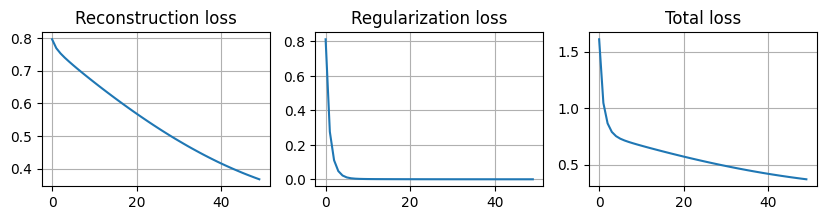

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10,2))

axs[0].plot(results["reconstruction_loss"])
axs[0].set_title("Reconstruction loss")
axs[0].grid()

axs[1].plot(results["regularization_loss"])
axs[1].set_title("Regularization loss")
axs[1].grid()

axs[2].plot(results["total_loss"])
axs[2].set_title("Total loss")
axs[2].grid()

plt.show()

# DirCNNVAE


## Prepare the Data (w x h x n_bands)
### crop 10%x10% of the image (HxW) since the size of the data become large

In [17]:

Y = data['X']  # Replace 'Y' with the correct key from print(data.keys())
Y = Y.astype('float32')
h,w,n_bands=Y.shape
Y=Y[0:int(0.1*h),0:int(0.1*w),:]
n_samples, n_bands =int(0.1*h)*int(0.1*w) , n_bands
Y = Y.reshape(-1, n_bands).astype("float32")
print(Y.shape)
# Normalize
Y = Y / Y.max()
Y = np.clip(Y, a_min=0, a_max=None)  # sets negative values to 0
dataset = HSIDataset(0,
                     Y , None, None,
                     n_ems, n_bands, n_samples,
                     None, None,
                     "Cuprite",
                     data_type="float32",
                     random_seed=1234)
dataset.Y=dataset.Y.reshape((int(0.1*h),int(0.1*w),n_bands))
print(dataset.Y.shape)

(3111, 224)
(51, 61, 224)


In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.image import extract_patches_2d

class HyperspectralPatchDataset(Dataset):
    def __init__(self, hyperspectral_image, patch_size=(12, 12)):
        """
        Args:
            hyperspectral_image: numpy array of shape (H, W, C)  [Height, Width, Spectral Bands]
            patch_size: tuple (patch_height, patch_width)
        """
        self.H, self.W, self.C = hyperspectral_image.shape  # (50, 80, C)
        self.patch_size = patch_size

        # Extract patches for each spectral band separately
        patches_list = [extract_patches_2d(hyperspectral_image[:, :, band], patch_size) for band in range(self.C)]

        # Stack along last axis -> (num_patches, 20, 20, C)
        self.patches = np.stack(patches_list, axis=-1)

    def __len__(self):
        return self.patches.shape[0]  # Number of patches

    def __getitem__(self, idx):
        patch = self.patches[idx]  # Shape: (20, 20, C)
        patch = torch.tensor(patch, dtype=torch.float32)  # Convert to PyTorch tensor
        patch = patch.permute(2, 0, 1)  # Change shape from (20, 20, C) → (C, 20, 20)
        return patch

# Load dataset
dataset = HyperspectralPatchDataset(dataset.Y)  # dataset.Y has shape (50, 80, n_bands)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




##Model


In [19]:
import torch
import torch.nn as nn

import numpy as np

from pprint import pprint


import torch
import torch.nn as nn

from abc import ABC, abstractmethod

class BaseVAE(nn.Module, ABC):
    """
        Skeleton for VAE-based architectures.
    """
    def __init__(self,
                 n_bands: int,
                 n_ems:   int):
        super().__init__()

        self.n_bands = n_bands
        self.n_ems   = n_ems

    @abstractmethod
    def _build_encoder(self) -> nn.Module:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _build_decoder(self) -> nn.Module:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def reparameterize(self, distribution_moment: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    @abstractmethod
    def process_latent(self, input: torch.Tensor):
        raise NotImplementedError

    @abstractmethod
    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, ...]:
        raise NotImplementedError


class DirCNNVAE(BaseVAE):
    r"""
        Dirichlet CNN VAE based on "Dirichlet Variational Autoencoder"
        by Weonyoung Joo, Wonsung Lee, Sungrae Park & Il-Chul Moon

        Theorem for reparameterization stating that
            if (X_k)_{k=1}^K \sim gamma(\alpha_k, \beta_k) i.i.d
            then if Y = (Y_1, ..., Y_K) such that \forall k
            where

        Sampling in the latent space:
            1) The encoder outputs the moments
            2) we sample
            3) we term-wise normalize by the sum

        Reparameterization trick applied on a random variable
        v \sim multigamma(\alpha, \beta \mathbb{1}_K) based
        thanks to an approximation of the inverse-CDF.
    """
    def __init__(self,
                 n_bands: int,
                 n_ems: int,
                 beta: float,
                 patch_size: int = 12,
                 encoder_activation_fn: callable = nn.LeakyReLU(),
                 encoder_batch_norm: bool = False):

        super().__init__(n_bands, n_ems)

        # beta = 1 so 1 / beta = 1

        self.patch_size=patch_size
        self.one_over_beta = torch.ones((n_ems,patch_size,patch_size))
        self.encoder_batch_norm    = encoder_batch_norm
        self.encoder_activation_fn = encoder_activation_fn

        self.encoder = self._build_encoder(encoder_activation_fn)
        self.decoder = self._build_decoder()

    def _build_encoder(self, encoder_activation_fn):
        layers = [
            #nn.Conv2d(self.n_bands, 48, kernel_size=3,padding=1, padding_mode="reflect", bias=False),
            nn.Conv2d(self.n_bands, 128, kernel_size=3, padding_mode="reflect", bias=False), # patch+1
            encoder_activation_fn,
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, kernel_size=3, padding_mode="reflect", bias=False), # patch+1
            encoder_activation_fn,
            nn.BatchNorm2d(64),

            nn.Conv2d(64, self.n_ems, kernel_size=1, bias=False),
            encoder_activation_fn,
            nn.BatchNorm2d(self.n_ems),
            nn.Softplus()  # Add Softplus correctly
        ]
        return nn.Sequential(*layers)


    def _build_decoder(self):
        decoder = nn.Conv2d(
            self.n_ems,
            self.n_bands,
            kernel_size=1,
            padding=2,
            padding_mode="reflect",
            bias=False,
        )
        decoder.weight.data.clamp_(min=0.0)
        return decoder


    def process_latent(self, alphas: torch.Tensor, eps=1e-6) -> torch.Tensor:
        r"""
            Input
            - alpha: params of the dircihlet distrib
            z_latent \sim Dir(\alpha)
        """
        v_latent = self.reparameterize(alphas)
        sum_v = torch.sum(v_latent, dim=1, keepdim=True)
        z_latent = v_latent / (sum_v + 1e-8)

        return z_latent


    def reparameterize(self, alphas: torch.Tensor) -> torch.Tensor:
        r"""
            - u \sim U(0,1)
            - v \sim multigamma(\alpha, \beta \mathbb{1}_K)

            inverse CDF of the multigamma distribution is
            v = CDF^{-1}(u ; \alpha, \beta \mathbb{1}_K) =
                          \beta^{-1}(u * \alpha * \Gamma(\alpha))^{1/\alpha}
        """
        u = torch.rand_like(alphas)

        clamped_alphas = torch.clamp(alphas, max=30) # clamped to avoid NaNs

        int1 = 1 / torch.max(clamped_alphas, 1e-8 * torch.ones_like(clamped_alphas))
        int2 = clamped_alphas.lgamma()
        int3 = int2.exp()
        int4 = int3 * u + 1e-12 # 1e-12 to avoid NaNs
        self.one_over_beta= torch.ones_like(u)

        v_latent = self.one_over_beta * (int4 * clamped_alphas) ** int1

        return v_latent




    def get_endmembers(self,
                       layer_idx: int = -1):
        """
            Endmembers are the last layer of the decoders in Palsson AE
        """
        with torch.no_grad():
            ems_tensor =  self.decoder.weight.data.mean((2, 3)).detach()
        return ems_tensor


    def to(self, device):
        """
        Moves the model and its associated buffers to a specified device.

        Parameters:
        - device (torch.device): The device to move the model to. This can be a CPU or a GPU.

        Returns:
        - self (DirCNNVAE): The model instance after moving to the specified device.
        """

        super().to(device)
        #self.one_over_beta = self.one_over_beta.to(device)
        return self



    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, ...]:
        if input.ndim == 1: input = input.unsqueeze(0)

        alphas   = self.encoder(input)
        z_latent = self.process_latent(alphas)
        output   = self.decoder(z_latent)

        return output, z_latent, alphas


if __name__ == "__main__":

    #from torchinfo import summary

    model = DirCNNVAE(n_bands=10, n_ems=3, beta=1.0 ,patch_size=12)
    input = torch.randn(1,10,12,12)
    output,z_latent,alphas=model(input)
    print(f"Output shape: {output.shape}")
    print(f"z_latent shape: {z_latent.shape}")
    print(f"Alphas shape: {alphas.shape}")
    print(z_latent[0,:,0,0])
    print(output[0,:,0,0])
    ems=model.get_endmembers()



Output shape: torch.Size([1, 10, 12, 12])
z_latent shape: torch.Size([1, 3, 8, 8])
Alphas shape: torch.Size([1, 3, 8, 8])
tensor([0.3442, 0.6109, 0.0448], grad_fn=<SelectBackward0>)
tensor([0.2588, 0.0623, 0.2764, 0.2861, 0.0057, 0.2254, 0.0902, 0.0070, 0.3108,
        0.0831], grad_fn=<SelectBackward0>)


In [20]:
#from model.dir_cnn_vae import DirCNNVAE

model = DirCNNVAE(n_bands                = n_bands,
                n_ems                 = n_ems,
                beta                  = 1.,
                patch_size=12,
                encoder_activation_fn = nn.LeakyReLU(),
                encoder_batch_norm    = True
)

In [21]:
import torch
import torch.nn as nn
# parameters of targeted Dirichlet distribution
concentration_sets = 4.0 * np.array([1.0 for i in range(n_ems)]).reshape(1,-1)
device='cuda' if torch.cuda.is_available() else 'cpu'
rec_loss_fn = SADLoss(mode='cnn',reduction='mean').to(device)#nn.MSELoss(reduction='mean').to(device) g
reg_loss_fn = GammaKL(torch.from_numpy(concentration_sets),mode='cnn',reduction='mean').to(device) #get_regularization_loss_fn(concentration_sets,loss_name= "gamma_div" ,mode='cnn').to(device)
optimizer_fn = get_optimizer("tf_rms")
optimizer    = optimizer_fn(model.parameters(),
                            0.05,
                            0.99)
n_epochs = 50
reg_factor =0.4
trainer = UnsupervisedTrainer()



In [22]:
total_loss, total_rec_loss, total_reg_loss = [], [], []
for epoch in range(n_epochs):
    total_rec_loss_patch, total_reg_loss_patch,total_loss_patch = 0., 0., 0.
    for batch in dataloader:
        batch = batch.to(device)
        output, z_latent, alphas = model(batch)

        rec_loss = rec_loss_fn(output, batch)
        reg_loss = reg_loss_fn(alphas)

        loss = rec_loss + reg_factor * reg_loss


        loss.backward()
        optimizer.step()

        # Enforce non-negativity constraint on decoder weights
        with torch.no_grad():
            model.decoder.weight.data.clamp_(min=0.0)

        optimizer.zero_grad()

        total_rec_loss_patch += rec_loss.item()
        total_reg_loss_patch += reg_loss.item()
        total_loss_patch += loss.item()

    total_loss.append(total_loss_patch / len(dataloader))
    total_rec_loss.append(total_rec_loss_patch / len(dataloader))
    total_reg_loss.append(total_reg_loss_patch / len(dataloader))

    print(f"Epoch {epoch}: Rec Loss = {total_rec_loss_patch / len(dataloader):.4f}, "
          f"Reg Loss = {total_reg_loss_patch / len(dataloader):.4f}")

Epoch 0: Rec Loss = 0.3619, Reg Loss = 2.5898
Epoch 1: Rec Loss = 0.3426, Reg Loss = 1.3664
Epoch 2: Rec Loss = 0.3317, Reg Loss = 0.8638
Epoch 3: Rec Loss = 0.3217, Reg Loss = 0.5894
Epoch 4: Rec Loss = 0.3126, Reg Loss = 0.4212
Epoch 5: Rec Loss = 0.3041, Reg Loss = 0.3105
Epoch 6: Rec Loss = 0.2963, Reg Loss = 0.2341
Epoch 7: Rec Loss = 0.2891, Reg Loss = 0.1795
Epoch 8: Rec Loss = 0.2824, Reg Loss = 0.1394
Epoch 9: Rec Loss = 0.2763, Reg Loss = 0.1095
Epoch 10: Rec Loss = 0.2706, Reg Loss = 0.0867
Epoch 11: Rec Loss = 0.2654, Reg Loss = 0.0691
Epoch 12: Rec Loss = 0.2606, Reg Loss = 0.0555
Epoch 13: Rec Loss = 0.2562, Reg Loss = 0.0447
Epoch 14: Rec Loss = 0.2520, Reg Loss = 0.0362
Epoch 15: Rec Loss = 0.2482, Reg Loss = 0.0294
Epoch 16: Rec Loss = 0.2447, Reg Loss = 0.0240
Epoch 17: Rec Loss = 0.2415, Reg Loss = 0.0196
Epoch 18: Rec Loss = 0.2386, Reg Loss = 0.0161
Epoch 19: Rec Loss = 0.2358, Reg Loss = 0.0132
Epoch 20: Rec Loss = 0.2332, Reg Loss = 0.0109
Epoch 21: Rec Loss = 0.

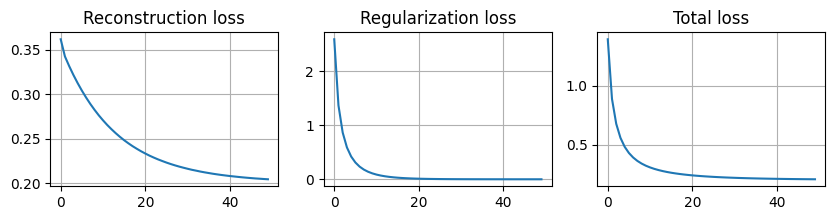

In [23]:
results={}
results['reconstruction_loss']=total_rec_loss
results['regularization_loss']=total_reg_loss
results['total_loss']=total_loss
fig, axs = plt.subplots(1, 3, figsize=(10,2))

axs[0].plot(results["reconstruction_loss"])
axs[0].set_title("Reconstruction loss")
axs[0].grid()

axs[1].plot(results["regularization_loss"])
axs[1].set_title("Regularization loss")
axs[1].grid()

axs[2].plot(results["total_loss"])
axs[2].set_title("Total loss")

axs[2].grid()

plt.show()